# 14장 모델의 성능 향상시키기
포도로 만든 와인은 고대 그리스 로마 시대부터 서양 음식의 기본이 된 오랜 양조주입니다. 와인은 빛깔에 따라 맑고 투명한 화이트 와인과 붉은색을 띠는 레드 와인으로 구분됩니다. 이번 실습을 위해 사용되는 데이터는 포르투갈 서북쪽 대서양과 맞닿아 있는 비뉴 베르드(Vinho Verde) 지방에서 만들어진 와인을 평가한 데이터입니다. 

레드 와인 샘플 1,599개를 등급과 맛, 산도를 측정해 분석하고 화이트 와인 샘플 4,898개를 마찬가지로 분석해 데이터를 만들었습니다. 원래는 UCI 저장소에 올라온 각각 분리된 데이터인데 두 데이터를 하나로 합쳐 레드 와인과 화이트 와인을 구분하는 실험을 진행해 보겠습니다.



### 1. 데이터의 확인과 검증셋
먼저 데이터를 불러와 대략적인 구조를 살펴보겠습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd

# 깃허브에 준비된 데이터를 가져옵니다.
!git clone https://github.com/taehojo/data.git

# 와인 데이터를 불러옵니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 데이터를 미리 보겠습니다.
df

fatal: destination path 'data' already exists and is not an empty directory.


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


샘플이 전체 6,497개 있습니다. 속성이 12개 있으며 13번째 열에 클래스가 기록되어 있습니다. 각 속성에 대한 정보는 다음과 같습니다.

<br><center>

|행 번호|의미|행 번호|의미|
|---|---|---|---|
|0|주석산 농동|7|밀도|
|1|아세트산 농도|8|pH|
|2|구연산 농도|9|황산칼륨 농도|
|3|잔류 당분 농도|10|알코올 도수|
|4|염화나트륨 농도|11|와인의 맛(0~10등급)|
|5|유리 아황산 농도|12|클래스(1:레드 와인, 0:화이트 와인)|
|6|총 아황산 농도|
</center><br>  


0~11번째 열에 해당하는 속성 12개를 ```X```로, 13번째 열을 ```y```로 정했습니다.

In [ ]:
# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

이제 딥러닝을 실행할 차례입니다. 앞서 우리는 학습(train) 데이터셋과 테스트(test) 데이터셋을 나누는 방법에 대해 알아봤습니다. 이 장에서는 검증셋(validation)을 고려해 보겠습니다.  
<br><center>
(그림. 14-1) 학습셋, 데스트셋, 검증셋<br>
<img src="https://drive.google.com/uc?id=1RUHPeVzw-a7m2_qtUsIHjvswWDrhr6Ce" width=300>
</center><br>  

학습이 끝난 모델을 테스트해 보기 위해 테스트 데이터셋의 마련하는 것이고 최적의 학습 파라미터를 찾기 위해 학습 과정에서 사용하는 데이터셋이 검증 데이터셋입니다. 검증 데이터셋을 사용하겠다고 설정하면 검증 데이터셋에 대해 테스트한 결과를 추적하면서 최적의 모델을 만들 수 있습니다. 검증셋은 ```model.fit()```함수로 전달하는 파라미터 **```validation_split```**의 값을 저정해 주면 만들어집니다. 그림(14-1)과 같이 전체 데이터셋의 80%를 학습 데이터셋으로 만들고 이 중 25%를 검증 데이터셋으로 하면 학습셋:검증셋:테스트셋의 비율이 60:20:20이 됩니다.



In [ ]:
# 학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
# 모델이 3개의 은닉층을 갖도록 구조를 설계(설정)합니다.
model.add(Dense(30,  input_dim=12, activation='relu'))    # 첫 번째 은닉층은 30개 노드
model.add(Dense(12, activation='relu'))                   # 두 번째 은닉층은 12개 노드
model.add(Dense(8, activation='relu'))                    # 세 번째 은닉층은 8개 노드로 구성
model.add(Dense(1, activation='sigmoid'))                 # 출력층
model.summary()

# 모델을 컴파일합니다.
# 이진 분류를 위한 손실 함수(lost function) : binary_crossentropy
# 옵티마이저 : adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                390       
                                                                 
 dense_13 (Dense)            (None, 12)                372       
                                                                 
 dense_14 (Dense)            (None, 8)                 104       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


먼저 세 개의 은닉층을 만들고 각각 30개, 12개, 8개의 노드를 만들었습니다. 아래 코드에서는 model을 생성합니다. 즉 모델을 학습 시킵니다. ```model.fit()``` 함수의 인자 ```validation_split``` 값을 할당했으므로 모델이 학습 데이터셋을 학습을 위한 데이터셋과 검증을 위한 데이터셋을 분리하여 모델 파라메타를 찾습니다. 

In [ ]:
# 모델을 실행합니다.

history=model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25) # 0.8 x 0.25 = 0.8 x 1/4 = 0.2

Epoch 1/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0389 - accuracy: 0.9895 - val_loss: 0.0415 - val_accuracy: 0.9892
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0384 - accuracy: 0.9897 - val_loss: 0.0412 - val_accuracy: 0.9892
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0418 - val_accuracy: 0.9862
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0378 - accuracy: 0.9890 - val_loss: 0.0480 - val_accuracy: 0.9854
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.9877 - val_loss: 0.0415 - val_accuracy: 0.9900
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 0.0446 - val_accuracy: 0.9862
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9887 - val_loss: 0.0420 - val_accuracy: 0.9854
Epoch 8/50
8/8 [=================

그리고 50번을 반복했을 때 학습 데이터셋에 대한 정확도(accuracy)는 94.97%로 나왔고 검증 데이터셋에 대한 정확도는 94.85% 나왔습니다. 꽤 높은 정확도군요. 아래에는 테스트 데이터 셋에 대한 정확도가 93.76%가 나왔습니다.

In [ ]:
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9808
Test accuracy: 0.9807692170143127


하지만 테스트 데이터셋에 대한 정확도는 약 93%가 나왔습니다. 이 것이 과연 최적의 결과일까요? 이제 여기에 여러 옵션을 더해 가면서 더 나은 모델을 만들어 가는 방법을 알아보겠습니다.

In [ ]:
history=model.fit(X_train, y_train, epochs=50, batch_size=500) 
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0870 - accuracy: 0.9719
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9721
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0860 - accuracy: 0.9717
Epoch 4/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.9719
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.9725
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9733
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0859 - accuracy: 0.9729
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0845 - accuracy: 0.9725
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0838 - accuracy: 0.9725
Epoch 10/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0844 - accuracy: 0.9723
Epoch 11/50
11/11 [

## 2. 모델 업데이트하기

에포크(epochs)는 학습을 몇 번 반복할 것인지 정해 줍니다. 에포크가 50이면 순전파와 역전파를 50번 실시한다는 뜻입니다. 학습을 많이 한다고 해서 모델 성능이 지속적으로 좋아지는 것은 아닙니다. 이를 적절히 정해 주는 것이 중요합니다. 만일 50번의 에포크 중 최적의 학습이 40번재에 이루어졌다면 어떻게 40번째 모델을 불러와 사용할 수 있을까요? 이번에는 매 에포크마다 모델의 정확도를 함께 기록하면서 저장하는 방법을 알아보겠습니다. 

먼저 모델이 어떤 식으로 저장될지 정합니다. 다음 코드는 ./data/model/all/ 폴더에 모델을 지정해 줍니다. 50번째 에포크의 검증 데이터셋에 대한 정확도가 0.9346이라면 50-0.9346.hdf5라는 이름으로 저장됩니다.

```
modelpath = './data/model/all/{epcho:02d}-{val_acuracy:.4f}.hdf5'
```

학습 중인 모델을 저장하는 함수는 케라스 API의 ```ModelCheckpoint()```입니다. 모델이 저장될 곳을 정하고 진행되는 상황을 모니터링할 수 있도록 ```verbos```는 1(```True```)로 설정합니다. 

``` 
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1)
```



### 기본 코드 불러오기

다시 필요 데이터셋을 불러오고 속성과 클래스를 분리한 다음 학습 데이터셋과 테스트 데이터셋으로 분리합니다. 모델 구조를 정의하고 컴파일합니다 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 깃허브에 준비된 데이터를 가져옵니다. 앞에서 이미 데이터를 가져왔으므로 주석 처리합니다. 2번 예제만 별도 실행 시 주석을 해제한 후 실행해주세요.
!git clone https://github.com/taehojo/data.git

# 와인 데이터를 불러옵니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

# 학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fatal: destination path 'data' already exists and is not an empty directory.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 30)                390       
                                                                 
 dense_9 (Dense)             (None, 12)                372       
                                                                 
 dense_10 (Dense)            (None, 8)                 104       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


### 모델의 저장 설정 및 실행
매 에포크(epochs) 마다 모델의 정확도를 출력합니다. 

In [ ]:
# 모델 저장의 조건을 설정합니다.
modelpath="./data/model/all/{epoch:02d}-{val_accuracy:.4f}.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1)

# 모델을 실행합니다. 
history=model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25, verbose=0, callbacks=[checkpointer])


print('---'*24)
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])


Epoch 1: saving model to ./data/model/all/01-0.7462.hdf5

Epoch 2: saving model to ./data/model/all/02-0.7462.hdf5

Epoch 3: saving model to ./data/model/all/03-0.7731.hdf5

Epoch 4: saving model to ./data/model/all/04-0.7700.hdf5

Epoch 5: saving model to ./data/model/all/05-0.8354.hdf5

Epoch 6: saving model to ./data/model/all/06-0.8931.hdf5

Epoch 7: saving model to ./data/model/all/07-0.9054.hdf5

Epoch 8: saving model to ./data/model/all/08-0.9238.hdf5

Epoch 9: saving model to ./data/model/all/09-0.9208.hdf5

Epoch 10: saving model to ./data/model/all/10-0.9369.hdf5

Epoch 11: saving model to ./data/model/all/11-0.9369.hdf5

Epoch 12: saving model to ./data/model/all/12-0.9354.hdf5

Epoch 13: saving model to ./data/model/all/13-0.9400.hdf5

Epoch 14: saving model to ./data/model/all/14-0.9392.hdf5

Epoch 15: saving model to ./data/model/all/15-0.9423.hdf5

Epoch 16: saving model to ./data/model/all/16-0.9362.hdf5

Epoch 17: saving model to ./data/model/all/17-0.9400.hdf5

Epoch

위 코드 cell 실행 결과로부터 에포그 수가 늘어나면 학습 데이터셋에 대한 정확도가 어느 정도 높아지다가 멈춘다는 것을 알 수 있었습니다. 에포크 50회까지 실행하는 동안 최고의 정확도가 발생한 에포크는 몇 회인가요?


## 3. 그래프로 과적합 확인하기

역전파를 50번 반복하면서 학습을 진행했습니다. 과연 이 반복 횟수는 적절했을까요? 학습의 반복 횟수가 너무 적으면 데이터셋의 패턴을 충분히 파악하지 못합니다. 하지만 학습을 너무 많이 반복하는 것도 좋지 않습니다. 너무 과한 학습은 13.2절에서 이야기한 바 있는데 과적합 현상을 불러오기 때문입니다. 적절한 학습 회수를 정하기 위해서는 검증 데이터셋과 테스트 데이터셋의 결과(정확도)를 그래프로 보는 것이 가장 좋습니다. 이를 확인하기 위해 학습을 길게 실행해 보고 결과를 알아보겠습니다. 먼저 에포크 수를 2000으로 늘려 학습을 2000회 시켜보겠습니다. (실행 시간이 다소 깁니다.)

In [ ]:
# 그래프 확인을 위한 긴 학습 
history=model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25)

Epoch 1/2000
8/8 [==============================] - 0s 14ms/step - loss: 0.1282 - accuracy: 0.9556 - val_loss: 0.1176 - val_accuracy: 0.9508
Epoch 2/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.1306 - accuracy: 0.9548 - val_loss: 0.1147 - val_accuracy: 0.9538
Epoch 3/2000
8/8 [==============================] - 0s 7ms/step - loss: 0.1261 - accuracy: 0.9543 - val_loss: 0.1160 - val_accuracy: 0.9577
Epoch 4/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.1249 - accuracy: 0.9543 - val_loss: 0.1153 - val_accuracy: 0.9577
Epoch 5/2000
8/8 [==============================] - 0s 7ms/step - loss: 0.1236 - accuracy: 0.9551 - val_loss: 0.1119 - val_accuracy: 0.9554
Epoch 6/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.1224 - accuracy: 0.9554 - val_loss: 0.1194 - val_accuracy: 0.9623
Epoch 7/2000
8/8 [==============================] - 0s 11ms/step - loss: 0.1235 - accuracy: 0.9554 - val_loss: 0.1134 - val_accuracy: 0.9600
Epoch 8/2000
8/

```
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25)
```

위 예제를 포함해 ```model.fit()```를 실행할 때 결과를 ```history```에 항상 저장했었습니다. ```history```에 저장된 데이터를 어떻게 활용하는지 보겠습니다. 

```model.fit()```은 학습을 진행하면서 매 에포크마다 결과를 출력합니다. 일반적으로 loss 값이 출려되고, ```model.compile()```에서 ```metrics```를 ```accuracy```로 지정하면 accuracy 값이 함께 출력됩니다.  
<br>

**loss**는 학습을 통해 구한 예측 값과 실제 값의 차이(오차)를 의미합니다. **accuracy**는 고려한 샘플들 중에서 정답을 맞춘 샘플이 몇 개인지의 비율(**정확도**)를 의미합니다. 학습 데이터셋으로 학습하고 해당 학습 데이터를 테스트해서 얻은 정확도입니다. 

이번 예제처럼 검증(validation) 데이터셋을 지정하면 **val_loss**가 함께 출력됩니다. 이때 metrics를 accuracy로 지정해두었다면 **val_accuracy** 값도 출력됩니다. val_loss는 학습한 모델을 검증 데이터셋에 적용해 얻은 오차이고, **val_accuracy**는 검증(validation) 데이터셋에 대한 정확도입니다. 


이러한 값이 저장된 ```history```는 파이썬 객체로, ```history.params```에는 ```model.fit()```의 설정 값들이, ```history.epoch```에는 에포크 정보가 들어 있습니다. 우리에게 필요한 loss, accuracy, val_loss, val_accuracy는 ```history.history```에 저장되어 있습니다. 이를 판다스 라이브러리로 불러와 각각의 값을 살펴보겠습니다. 

In [ ]:
# history에 저장된 학습 결과를 확인해 보겠습니다. 
hist_df=pd.DataFrame(history.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.128191,0.955607,0.117597,0.950769
1,0.130636,0.954837,0.114714,0.953846
2,0.126099,0.954324,0.116039,0.957692
3,0.124854,0.954324,0.115256,0.957692
4,0.123643,0.955094,0.111913,0.955385
...,...,...,...,...
1995,0.030293,0.992045,0.046942,0.986923
1996,0.029353,0.993328,0.047144,0.986154
1997,0.030105,0.991789,0.047338,0.984615
1998,0.031938,0.991789,0.047445,0.985385


2000번의 학습 결과가 저장되어 있음을 알 수 있습니다. 학습한 모델을 검증(validation) 데이터셋에 적용해 얻은 오차(val_loss)는 ```y_vloss```에 저장하고 학습(train) 데이터셋에서 적용해 얻은 오차(loss)는 ```y_loss```에 저장하겠습니다.

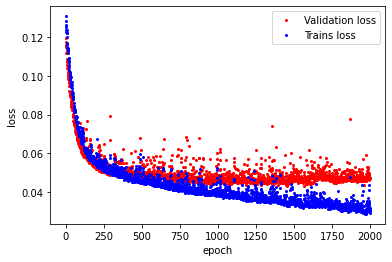

In [ ]:
# y_vloss에 검증(validation) 데이터셋에 대한 오차를 저장합니다.
y_vloss=hist_df['val_loss']

# y_loss에 학습(train) 데이터셋의 오차를 저장합니다.
y_loss=hist_df['loss']

# x에 에포크 값을 지정하고
# 검증 데이터셋에 대한 오차를 빨간색으로, 학습셋에 대한 오차를 파란색으로 표시합니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label='Validation loss')
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label='Trains loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


<br><center>
(그림. 14-2) 학습셋에서 얻은 오차와 검증셋에서 얻은 오차 비교<br>
<img src="https://drive.google.com/uc?id=1wzW5jYKbO3B4iUL8D7p8_jaJAwHbO9vS" width=500>
</center><br>
그림(14.2)의 범례에서 "Testset_loss"는 검증(validation) 데이터셋에 대한 에러를 의미합니다.  

<br><br>
(강사 - 교재에서는 그림(14-2)와 같은 그래프가 나온다고 하는데 이것은 다소 인위적을로 만든 그래프 같다는 생각이 듬. 위 코드를 실제로 수행해 얻은 위 그래프의 의미를 다시 생각해 보시길 바람. 여기서 이해해야 할 핵심 내용은 에포크가 증가함에 따라 학습 데이터셋에 대한 오차는 줄어들지만 검증 데이터셋에 대한 오차는 오히려 증가 할 수 있다는 것이다. **모델이 학습 데이터셋에 과적합되어감에따라 검증 데이터셋에 대해서는 오히려 에러가 증가한다는 것입니다. 그림(14-2)를 보면 에포크의 증가에 따라 검증 데이터셋에 대한 에러가 감소하가다 다시 서서히 증가하는 것을 볼 수 있다. 따라서 검증 데이터셋에 대한 에러가 증가하기 전에 학습을 멈춰 학습 데이터에 과적합되는 것을 막아야 최고의 성능을 기대할 수 있다.**)



## 4. 학습의 자동 중단

텐서플로에 포함된 케라스 API는 ```EarlyStopping()``` 함수를 제공합니다. 학습이 진행되어도 검증 데이터셋에 대한 오차가 줄어들지 않으면 학습을 자동으로 멈추게 하는 함수이니다. 이를 조금 전에 배운 ```ModelCheckpoint()``` 함수와 함께 사용해 보면서 최적의 모델을 저장해 보겠습니다. 먼저 다음과 같이 ```EarlStopping()``` 함수를 호출합니다.

```
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)
```

monitor 옵션은 model.fit() 함수의 실행 결과 중 어떤 것을 이용할지 정합니다. 검증(validation) 데이터셋의 오차(val_loss)로 지정하겠습니다. patience 옵션은 지정된 값이 몇 번 이상 향상되지 않으면 학습을 종료시킬지 정합니다. monitor='val_loss', patience=20이라고 지정하면 검증 데이터셋의 오차가 20번 이상 나자지지 않을 경우 학습을 종료하라는 의미입니다. 

모델 저장에 관한 설명은 앞 절에서 사용한 내용을 그대로 따르겠습니다. 다만 이번에는 최고의 모델 하나만 저장되게끔 해보겠습니다. 이를 위해 저장된 모델 이름에 에포크나 정확도 정보를 포함하지 않고 ModelCheckpoint()의 save_best_only 옵션을 True로 설정합니다. 

```
modelpath = "./data/model/Ch14-4-bestmodel.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, mointor='val_loss', verbose=0, save_best_only=True)
```
모델을 실행합니다.  자동으로 최적의 에포트를 찾아 멈출 예정이므로 epochs는 넉넉하게 설정해 줍니다.
```
history = model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.5, verbos=1, callbacks=[early_stopping_callback, checkpointer])
```

앞서 만든 기본 코드에 다음과 같이 새로운 코드를 붙여서 실행해 보겠습니다.

### 기본 코드 불러오기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd

# 깃허브에 준비된 데이터를 가져옵니다. 앞에서 이미 데이터를 가져왔으므로 주석 처리합니다. 2번 예제만 별도 실행 시 주석을 해제한 후 실행해주세요.
# !git clone https://github.com/taehojo/data.git

# 와인 데이터를 불러옵니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

# 학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                390       
                                                                 
 dense_5 (Dense)             (None, 12)                372       
                                                                 
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


### 학습의 자동 중단 및 최적화 모델 저장

In [ ]:
# 학습이 언제 자동 중단될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# 최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 모델을 실행합니다.
history=model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback,checkpointer])


Epoch 1/2000
8/8 [==============================] - 1s 20ms/step - loss: 0.6501 - accuracy: 0.7696 - val_loss: 0.3804 - val_accuracy: 0.8415
Epoch 2/2000
8/8 [==============================] - 0s 7ms/step - loss: 0.3741 - accuracy: 0.8576 - val_loss: 0.3605 - val_accuracy: 0.8485
Epoch 3/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.3223 - accuracy: 0.8873 - val_loss: 0.3492 - val_accuracy: 0.8854
Epoch 4/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.3172 - accuracy: 0.8886 - val_loss: 0.3086 - val_accuracy: 0.8992
Epoch 5/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.2896 - accuracy: 0.9071 - val_loss: 0.2984 - val_accuracy: 0.8877
Epoch 6/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.2744 - accuracy: 0.9161 - val_loss: 0.2837 - val_accuracy: 0.9054
Epoch 7/2000
8/8 [==============================] - 0s 7ms/step - loss: 0.2572 - accuracy: 0.9187 - val_loss: 0.2651 - val_accuracy: 0.9031
Epoch 8/2000
8/8 [=

에포크를 2,000번 설정했지만 357번에서 멈췄습니다. 이때의 모델이 model 폴더에 Ch14-4-bestmodel.hdf5라는 이름으로 저장된 것을 확인하십시요.

이제 지금까지 만든 모델을 테스트(test)해 보겠습니다. 따로 보관하여 학습 과정에서 사용되지 않은 테스트 데이터셋을 이 모델에 적용했을 때의 정확도를 확인하기 위해 아래와 같이 코딩하였습니다. 

In [ ]:
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9877
Test accuracy: 0.9876922965049744


정확도가 98.23%입니다. 14.1절에서 실행했던 기본 소스 코드가 94.15%의 정확도를 보였던 것과 비교하면 모델 성능이 대폭 향상된 것을 알 수 있습니다.

#### [과제] 
과제 1 - 피마 인디언 데이터를 k 겹 교차 검증 법을 활용하여 모델을 설계하고 예측 정확도를 평가하는 코드를 작성하세요.

과제 2 - 피마 인디언 데이터를 활용, 이번 장에서 진행한 내용(모델 업데이트, 그래프로 과적합 확인, 학습의 자동 중단)을 실행 하는 코드를 작성하시오